In [110]:
# @title Preprocessing
import pandas as pd

games = pd.read_csv('games.csv')
games = games[['season', 'week', 'date', 'away', 'home', 'first_downs_away', 'first_downs_home',
               'passing_yards_away', 'passing_yards_home', 'rushing_yards_away', 'rushing_yards_home',
               'total_yards_away', 'total_yards_home', 'rushing_attempts_away', 'rushing_attempts_home',
               'fumbles_away', 'fumbles_home', 'int_away', 'int_home', 'turnovers_away', 'turnovers_home',
               'drives_away', 'drives_home', 'def_st_td_away', 'def_st_td_home', 'possession_away',
               'possession_home', 'score_away', 'score_home']]
games.to_csv('filtered_games.csv', index=True)

In [111]:
# @title Preprocessing
import statistics

# read data from uploaded files
games = pd.read_csv('filtered_games.csv')
players = pd.read_csv('players.csv')
master = pd.read_excel('_master.xlsx')

dfs = [games, players, master]
print(len(games), len(players), len(master))

# strip whitespace from str elements
for df in dfs:
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


# add position from players to games
master_and_players_df = master.merge(players[['displayName', 'position']], left_on='player', right_on= 'displayName', how='inner')
master_and_players_df.drop('displayName', axis= 1, inplace= True)

# Get list of positions to consider in analysis
positions = []
for index, row in master_and_players_df.iterrows():
  pos = row['position']
  if pos not in positions:
    positions.append(pos)
print('Positions being considered: ', positions)

'''
Next I will add to each row of games new columns indicating injuries, by:
  - Adding new column to store each type of injury as True or False:
    bool: home_WR_injured, home_RB_injured, ... , away_SS_injured, away_FB_injured
'''

new_columns = [f'home_{pos}_injured' for pos in positions]
for col in new_columns:
  games[col] = False
# the below for loop will add injured positions to a list which resets for each game (home team only)
# could then do a for item in list: if item == [certain position]: current_row['home_[position]_injured'] = True
for game_index, game_row in games.iterrows():
  home_team = game_row['home']
  season = game_row['season']
  week = game_row['week']

  home_team_injuries = []

  for index, row in master_and_players_df.iterrows():
    if row['year'] == season and row['week'] == week and row['team'] == home_team and row['injured'] == True:
      # for each game in games, if all of the above are true, then we are looking at an injured player on the home team during that game
      home_team_injuries.append(row['position'])
  if home_team_injuries:
    for item in home_team_injuries:
      column_name = f'home_{item}_injured'
      games.at[game_index, column_name] = True

games_columns = games.columns.tolist()

'''
New Columns (one for each potential injured position for home team) have been added to the games df
These columns have been populated with T/F values which vary by week according to the home team's injured players
Now we can filter and derive descriptive statistics
'''
# print("HEAD: \n", games.head(50))
# print("TAIL: \n", games.tail(50))
# the above print statements demonstrate that new columns were successfully populated with T/F values

# get_stats returns a filtered df consisting of all of the rows in games where specified position in injured,
# and all the columns which are specified. Stats can then be calculated as:
# df = get_stats(stats, position)
# df['total_yards_home'].mean() and so forth
def get_stats(stats, position):
  new_stats = stats + ['season', 'week', 'date', 'away', 'home']

  position_column = f'home_{position}_injured'
  position_df = games[games[position_column]]
  filtered_position_df = position_df.loc[:, new_stats]
  return filtered_position_df

stats = ['first_downs_home', 'passing_yards_home',
         'rushing_yards_home', 'total_yards_home',
         'possession_home', 'score_home']

769 1303 15611
Positions being considered:  ['WR', 'RB', 'TE', 'QB', 'HB', 'CB', 'SS', 'FB']


In [112]:
# @title Preview games and master_and_players_df
print(games.columns.tolist())
display(games.head())
display(master_and_players_df.head())

['Unnamed: 0', 'season', 'week', 'date', 'away', 'home', 'first_downs_away', 'first_downs_home', 'passing_yards_away', 'passing_yards_home', 'rushing_yards_away', 'rushing_yards_home', 'total_yards_away', 'total_yards_home', 'rushing_attempts_away', 'rushing_attempts_home', 'fumbles_away', 'fumbles_home', 'int_away', 'int_home', 'turnovers_away', 'turnovers_home', 'drives_away', 'drives_home', 'def_st_td_away', 'def_st_td_home', 'possession_away', 'possession_home', 'score_away', 'score_home', 'home_WR_injured', 'home_RB_injured', 'home_TE_injured', 'home_QB_injured', 'home_HB_injured', 'home_CB_injured', 'home_SS_injured', 'home_FB_injured']


,Unnamed: 0,season,week,date,away,home,first_downs_away,first_downs_home,passing_yards_away,passing_yards_home,...,score_away,score_home,home_WR_injured,home_RB_injured,home_TE_injured,home_QB_injured,home_HB_injured,home_CB_injured,home_SS_injured,home_FB_injured
0,0,2020,1,9/10/20,Texans,Chiefs,21,28,242,203,...,20,34,False,False,False,False,False,False,False,False
1,1,2020,1,9/13/20,Seahawks,Falcons,22,28,299,434,...,38,25,False,False,False,False,False,False,False,False
2,2,2020,1,9/13/20,Jets,Bills,15,31,202,306,...,17,27,False,False,False,False,False,False,False,False
3,3,2020,1,9/13/20,Bears,Lions,26,25,214,288,...,27,23,False,False,False,False,False,False,False,False
4,4,2020,1,9/13/20,Packers,Vikings,31,25,364,248,...,43,34,False,False,False,False,False,False,False,False


,year,week,player,team,injured,description,position
0,2022,1,A.J. Green,Cardinals,False,NaN,WR
1,2022,2,A.J. Green,Cardinals,False,NaN,WR
2,2022,3,A.J. Green,Cardinals,False,NaN,WR
3,2022,5,A.J. Green,Cardinals,False,NaN,WR
4,2022,6,A.J. Green,Cardinals,False,NaN,WR


Block 1 does several things to set up for analysis.

First, it reads data from 3 files and strips elements of whitespace

Then, it creates a new df which includes the position of each player in _master. the new df has player info (name, team, position) and injury status for each game.

Next, it generates a list of positions (called positions) which are to be considered in analysis. This list is not comprehensive of all possible NFL positions due to imperfect data but does include major positions which are the most applicable.

Then, it adds to each row of games df new columns indicating injuries, by adding new column to store each type of injury as True or False:
- bool: home_WR_injured, home_RB_injured, ... , away_SS_injured, away_FB_injured
- These values consider the home team and change each week depending on updated injury status

Finally, it contains the function get_stats which takes in two arguments, stats and position, and returns a df containing all rows from games df where the specified position is injured, and all columns specified (by default, columns for year, week, date, home/away team are included)
- a list of stats is declared for convenient passing into get_stats function which includes ['first_downs_home', 'passing_yards_home',
 'rushing_yards_home', 'total_yards_home', 'possession_home', 'score_home']
 - This list can be updated any time


Now data is ready to be analyzed. The next code chunk can get descriptive statistics.

In [113]:
# @title Preprocessing: Add away team injury data in the same format as home team ('away_{position}_injured')


new_away_columns = [f'away_{pos}_injured' for pos in positions]
for col in new_away_columns:
  games[col] = False
# the below for loop will add injured positions to a list which resets for each game
# could then do a for item in list: if item == [certain position]: current_row['away_[position]_injured'] = True
for game_index, game_row in games.iterrows():
  away_team = game_row['away']
  season = game_row['season']
  week = game_row['week']

  away_team_injuries = []

  for index, row in master_and_players_df.iterrows():
    if row['year'] == season and row['week'] == week and row['team'] == away_team and row['injured'] == True:
      # for each game in games, if all of the above are true, then we are looking at an injured player on the away team during that game
      away_team_injuries.append(row['position'])
  if away_team_injuries:
    for item in away_team_injuries:
      column_name = f'away_{item}_injured'
      games.at[game_index, column_name] = True

games_columns = games.columns.tolist()

print(games['away_RB_injured'].head())


0    False
1    False
2    False
3    False
4    False
Name: away_RB_injured, dtype: bool


In [114]:
# @title Preprocessing: update games to include home team win/loss

# create a new column 'home_win' based on the comparison of 'score_home' and 'score_away'
games['home_win'] = games['score_home'] > games['score_away']
display(games.tail(25))

,Unnamed: 0,season,week,date,away,home,first_downs_away,first_downs_home,passing_yards_away,passing_yards_home,...,home_FB_injured,away_WR_injured,away_RB_injured,away_TE_injured,away_QB_injured,away_HB_injured,away_CB_injured,away_SS_injured,away_FB_injured,home_win
744,744,2022,15,12/18/22,Cowboys,Jaguars,24,26,243,311,...,False,True,False,False,False,False,False,False,False,True
745,745,2022,15,12/18/22,Chiefs,Texans,33,18,313,125,...,False,True,False,False,False,False,False,False,False,False
746,746,2022,15,12/18/22,Cardinals,Broncos,13,23,167,156,...,False,True,False,False,False,False,False,False,False,True
747,747,2022,15,12/18/22,Patriots,Raiders,19,18,112,211,...,False,True,False,True,False,False,False,False,False,True
748,748,2022,15,12/18/22,Titans,Chargers,17,23,157,291,...,False,True,True,False,False,False,False,False,False,True
749,749,2022,15,12/18/22,Bengals,Buccaneers,20,25,184,304,...,False,True,False,False,False,True,False,False,False,False
750,750,2022,15,12/18/22,Giants,Commanders,19,20,160,228,...,False,True,True,False,False,False,False,False,False,False
751,751,2022,15,12/19/22,Rams,Packers,13,27,84,207,...,False,False,False,True,False,False,False,False,False,True
752,752,2022,16,12/22/22,Jaguars,Jets,19,10,218,161,...,False,False,False,True,False,False,False,False,False,False
753,753,2022,16,12/24/22,Bills,Bears,20,11,172,129,...,False,True,False,False,False,False,False,False,False,False


In [115]:
# @title Preprocessing: Convert Possession Attributes to Time datatype
# Possession times can now be averaged etc. & used in analysis
from datetime import datetime, time

# Assuming games is your DataFrame
time_columns = ['possession_away', 'possession_home']

# Function to convert string to time
def convert_to_time(time_str, column, index):
    try:
        # Check if time_str is not already a datetime.time object
        if not isinstance(time_str, time):
            # Trim the last 3 characters if the string is longer than 5 characters
            trimmed_str = time_str[:-3] if len(time_str) > 5 else time_str

            # Create a datetime.time object
            return datetime.strptime(trimmed_str, '%M:%S').time()

    except ValueError:
        # Handle invalid formats
        print(f"Invalid time format at row {index}, column {column}: {time_str}")

    return time_str  # Return original value

# Apply the convert_to_time function to the specified columns
for col in time_columns:
    games[col] = games[col].apply(lambda cell: convert_to_time(cell, col, games.index[0]))

print(type(games['possession_home'][4]))
print(games['possession_home'].head(15))

<class 'datetime.time'>
0     00:34:47
1     00:29:24
2     00:41:17
3     00:30:55
4     00:18:44
5     00:34:49
6     00:29:21
7     00:28:48
8     00:26:37
9     00:29:58
10    00:29:50
11    00:31:23
12    00:28:34
13    00:35:38
14    00:28:16
Name: possession_home, dtype: object


In [116]:
print(games.columns.tolist())

['Unnamed: 0', 'season', 'week', 'date', 'away', 'home', 'first_downs_away', 'first_downs_home', 'passing_yards_away', 'passing_yards_home', 'rushing_yards_away', 'rushing_yards_home', 'total_yards_away', 'total_yards_home', 'rushing_attempts_away', 'rushing_attempts_home', 'fumbles_away', 'fumbles_home', 'int_away', 'int_home', 'turnovers_away', 'turnovers_home', 'drives_away', 'drives_home', 'def_st_td_away', 'def_st_td_home', 'possession_away', 'possession_home', 'score_away', 'score_home', 'home_WR_injured', 'home_RB_injured', 'home_TE_injured', 'home_QB_injured', 'home_HB_injured', 'home_CB_injured', 'home_SS_injured', 'home_FB_injured', 'away_WR_injured', 'away_RB_injured', 'away_TE_injured', 'away_QB_injured', 'away_HB_injured', 'away_CB_injured', 'away_SS_injured', 'away_FB_injured', 'home_win']


In [117]:
# @title Correlation Matrix with injured positions and select metrics
import pandas as pd

columns_to_check = ['home_QB_injured', 'home_RB_injured', 'home_WR_injured', 'home_TE_injured',
                     'home_SS_injured', 'home_CB_injured', 'home_FB_injured', 'home_HB_injured']

'''
# Convert back to boolean
for column in columns_to_check:
    if games[column].dtype == int:
        games[column] = games[column].astype(bool)


# Check and convert to numerical if boolean
for column in columns_to_check:
    if games[column].dtype == bool:
        games[column] = games[column].astype(int)
'''

selected_columns = ['home_QB_injured', 'home_RB_injured', 'home_WR_injured', 'home_TE_injured',
                          'home_SS_injured', 'home_CB_injured', 'home_FB_injured', 'home_HB_injured',
                          'passing_yards_home', 'rushing_yards_home', 'first_downs_home', 'int_home', 'int_away',
                          'drives_home', 'fumbles_home', 'turnovers_home', 'score_home']

# Select relevant columns for correlation analysis
selected_columns_df = games[selected_columns]

# Calculate the correlation matrix
correlation_matrix = selected_columns_df.corr()

# Display the correlation matrix
display(correlation_matrix)


,home_QB_injured,home_RB_injured,home_WR_injured,home_TE_injured,home_SS_injured,home_CB_injured,home_FB_injured,home_HB_injured,passing_yards_home,rushing_yards_home,first_downs_home,int_home,int_away,drives_home,fumbles_home,turnovers_home,score_home
home_QB_injured,1.000000,0.109145,0.040099,-0.009303,NaN,-0.036300,NaN,-0.050154,-0.112916,-0.005509,-0.116913,0.000112,-0.029634,0.028088,-0.032290,-0.019442,-0.053828
home_RB_injured,0.109145,1.000000,-0.034211,-0.095926,NaN,0.094292,NaN,-0.010788,-0.009099,0.010942,-0.023297,0.017693,-0.076733,0.050495,0.061223,0.050793,-0.042321
home_WR_injured,0.040099,-0.034211,1.000000,0.022928,NaN,0.012036,NaN,0.199788,0.043500,0.001848,0.012399,-0.012645,0.037660,0.001560,-0.012124,-0.017171,0.052230
home_TE_injured,-0.009303,-0.095926,0.022928,1.000000,NaN,-0.034036,NaN,-0.003660,-0.018082,-0.021527,-0.043749,-0.025859,-0.000561,0.019916,0.013711,-0.011826,0.012154
home_SS_injured,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_CB_injured,-0.036300,0.094292,0.012036,-0.034036,NaN,1.000000,NaN,-0.016362,-0.042481,-0.043711,-0.034494,0.001422,-0.042174,-0.040023,0.090859,0.056059,-0.080749
home_FB_injured,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_HB_injured,-0.050154,-0.010788,0.199788,-0.003660,NaN,-0.016362,NaN,1.000000,0.111551,0.006545,0.106074,0.019311,0.034197,0.035562,-0.023682,0.000701,0.066702
passing_yards_home,-0.112916,-0.009099,0.043500,-0.018082,NaN,-0.042481,NaN,0.111551,1.000000,-0.247632,0.587247,-0.005921,-0.106265,0.078545,0.046832,0.023718,0.414227
rushing_yards_home,-0.005509,0.010942,0.001848,-0.021527,NaN,-0.043711,NaN,0.006545,-0.247632,1.000000,0.368457,-0.059999,0.120438,-0.009001,-0.089582,-0.100860,0.373177


In [118]:
# @title list of input (by position) and output variable dtypes
cols = ['home_QB_injured', 'home_RB_injured', 'home_WR_injured', 'home_TE_injured',
        'home_SS_injured', 'home_CB_injured', 'home_FB_injured', 'home_HB_injured',
        'passing_yards_home', 'rushing_yards_home', 'first_downs_home', 'int_home',
        'int_away', 'drives_home', 'fumbles_home', 'turnovers_home', 'score_home']
for col in cols:
  print(type(games[col][5]))

'''
'away_QB_injured', 'away_RB_injured', 'away_WR_injured', 'away_TE_injured',
        'away_CB_injured', 'away_HB_injured', 'away_FB_injured', 'away_SS_injured',
'''

<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


"\n'away_QB_injured', 'away_RB_injured', 'away_WR_injured', 'away_TE_injured',\n        'away_CB_injured', 'away_HB_injured', 'away_FB_injured', 'away_SS_injured',\n"

In [119]:
'''
columns_to_convert = ['home_QB_injured', 'home_RB_injured', 'home_WR_injured',
                      'home_TE_injured', 'home_SS_injured', 'home_CB_injured']

df[columns_to_convert] = df[columns_to_convert].astype(bool)
'''

"\ncolumns_to_convert = ['home_QB_injured', 'home_RB_injured', 'home_WR_injured',\n                      'home_TE_injured', 'home_SS_injured', 'home_CB_injured']\n\ndf[columns_to_convert] = df[columns_to_convert].astype(bool)\n"

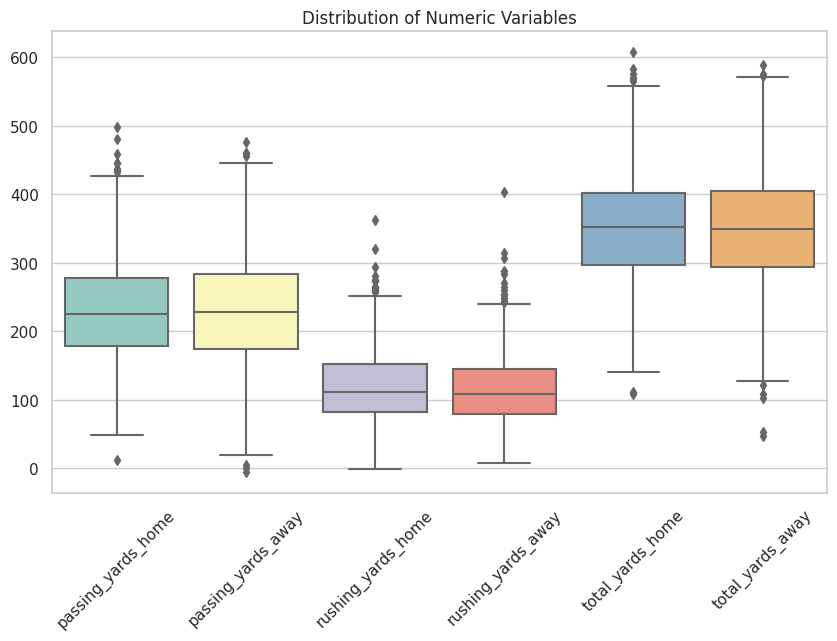

In [120]:
# @title Univariate Analysis
import matplotlib.pyplot as plt
import seaborn as sns

num_vars = ['passing_yards_home', 'passing_yards_away', 'rushing_yards_home', 'rushing_yards_away',
            'total_yards_home', 'total_yards_away']
num_df = games[num_vars]

sns.set(style="whitegrid")

# Visualize the distribution of each variable using boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(data=num_df, palette="Set3")
plt.title('Distribution of Numeric Variables')
plt.xticks(rotation=45)
plt.show()

In [121]:
# @title convert possession time to float minutes
df = games
df['possession_home_minutes'] = df['possession_home'].apply(lambda x: x.minute + x.second / 60)
df['possession_away_minutes'] = df['possession_away'].apply(lambda x: x.minute + x.second / 60)

display(df.head())

,Unnamed: 0,season,week,date,away,home,first_downs_away,first_downs_home,passing_yards_away,passing_yards_home,...,away_RB_injured,away_TE_injured,away_QB_injured,away_HB_injured,away_CB_injured,away_SS_injured,away_FB_injured,home_win,possession_home_minutes,possession_away_minutes
0,0,2020,1,9/10/20,Texans,Chiefs,21,28,242,203,...,False,False,False,False,False,False,False,True,34.783333,25.216667
1,1,2020,1,9/13/20,Seahawks,Falcons,22,28,299,434,...,False,False,False,False,False,False,False,False,29.400000,30.600000
2,2,2020,1,9/13/20,Jets,Bills,15,31,202,306,...,False,False,False,False,False,False,False,True,41.283333,18.716667
3,3,2020,1,9/13/20,Bears,Lions,26,25,214,288,...,False,False,False,False,False,False,False,False,30.916667,29.083333
4,4,2020,1,9/13/20,Packers,Vikings,31,25,364,248,...,False,False,False,False,False,False,False,False,18.733333,41.266667


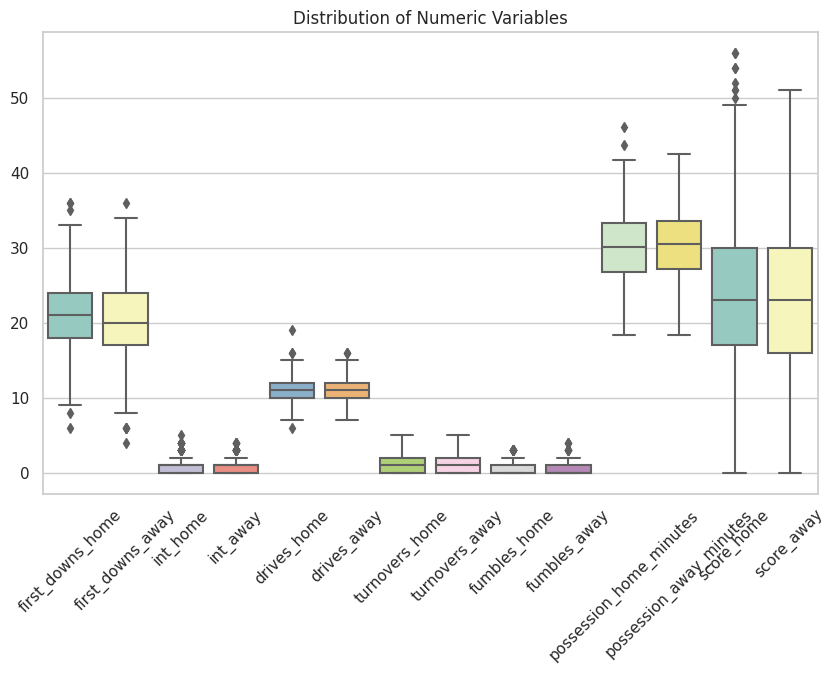

In [122]:
# @title Univariate Analysis cont.

num_vars = ['first_downs_home', 'first_downs_away', 'int_home',
            'int_away', 'drives_home', 'drives_away', 'turnovers_home', 'turnovers_away', 'fumbles_home',
            'fumbles_away', 'possession_home_minutes', 'possession_away_minutes', 'score_home', 'score_away']

num_df = df[num_vars]

sns.set(style="whitegrid")

# Visualize the distribution of each variable using boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(data=num_df, palette="Set3")
plt.title('Distribution of Numeric Variables')
plt.xticks(rotation=45)
plt.show()

In [123]:
# @title Checking Outliers
weird_df = games[(games['passing_yards_home'] < 10) | (games['passing_yards_away'] < 10) | (games['rushing_yards_home'] < 10) | (games['rushing_yards_away'] < 10)]
display(weird_df[['date', 'home', 'away', 'passing_yards_home', 'passing_yards_away', 'rushing_yards_home', 'rushing_yards_away', 'home_QB_injured', 'away_QB_injured', 'home_win']])

,date,home,away,passing_yards_home,passing_yards_away,rushing_yards_home,rushing_yards_away,home_QB_injured,away_QB_injured,home_win
131,11/8/20,Buccaneers,Saints,186,282,8,138,False,False,False
290,9/26/21,Browns,Bears,203,1,215,46,False,False,True
318,10/3/21,Patriots,Buccaneers,295,261,-1,120,False,False,False
452,12/12/21,Titans,Jaguars,161,184,102,8,False,False,True
497,1/2/22,Bears,Giants,162,-6,87,161,False,False,True
522,1/9/22,Bills,Jets,254,5,170,48,False,False,True
590,10/2/22,Buccaneers,Chiefs,373,228,3,189,False,False,False


In [124]:
# @title Biserial corr w/ list of input (by position) and output variables
from scipy.stats import pointbiserialr

correlation_values = {}
for column in cols:
    if games[column].dtype == 'bool':
        correlation, p_value = pointbiserialr(games[column], games['passing_yards_home'])
        correlation_values[column] = correlation

# Print or visualize the results
print(correlation_values)


{'home_QB_injured': -0.11291556965643369, 'home_RB_injured': -0.00909895167861716, 'home_WR_injured': 0.043499578266812125, 'home_TE_injured': -0.018081709169112503, 'home_SS_injured': nan, 'home_CB_injured': -0.04248062015704893, 'home_FB_injured': nan, 'home_HB_injured': 0.1115510336478408}


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


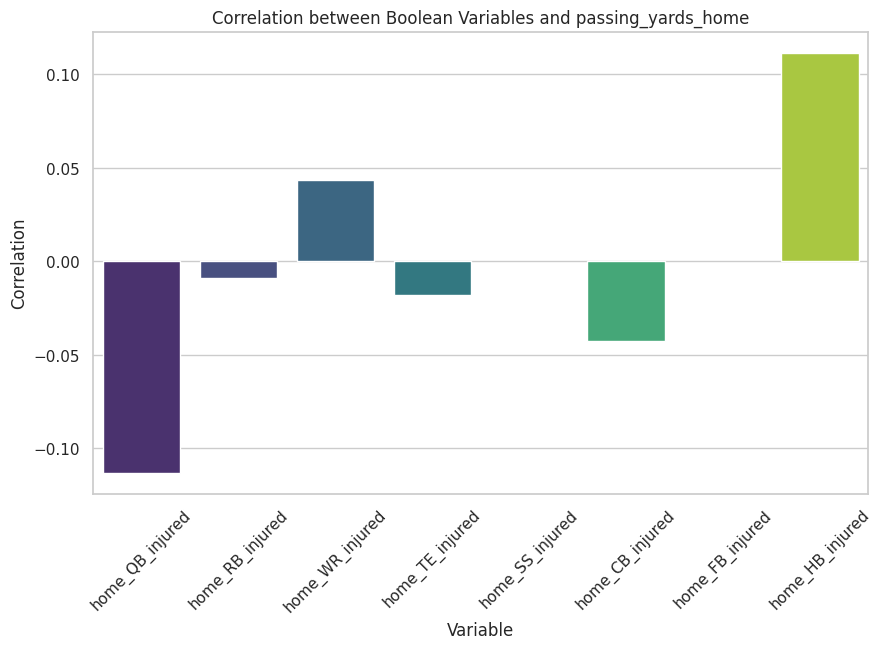

In [125]:
# @title Passing Yards Correlation Bar Chart
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame from the dictionary
correlation_df = pd.DataFrame(list(correlation_values.items()), columns=['Variable', 'Correlation'])

# Plot the correlations
plt.figure(figsize=(10, 6))
sns.barplot(x='Variable', y='Correlation', data=correlation_df, palette='viridis')
plt.title('Correlation between Boolean Variables and passing_yards_home')
plt.xlabel('Variable')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.show()


Weak Negative correlation found between injured QBs and passing yards. Other correlations too weak to be considered or noted.

While weak, the association between injured QBs and decreased passing yards has been found consistently in every analysis conducted, and is congruent with intuition, so it should be noted

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


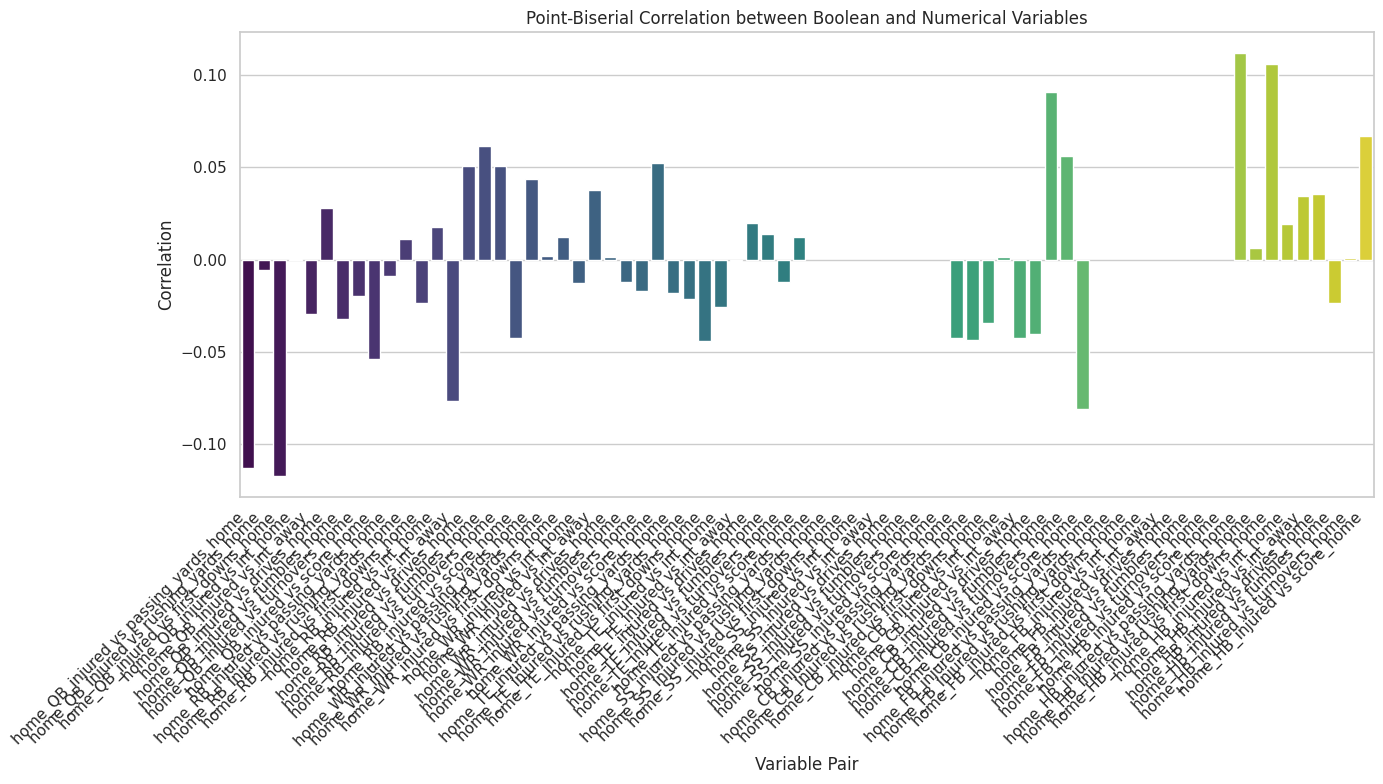

In [126]:
# @title Point Biserial all variables
from scipy.stats import pointbiserialr

correlation_values = {}

# get boolean variables and numerical variables
bool_vars = [col for col in cols if games[col].dtype == 'bool']
num_vars = [col for col in cols if games[col].dtype in ['int64', 'float64']]

#  point-biserial correlation for each combination
for bool_var in bool_vars:
    for num_var in num_vars:
        correlation, p_value = pointbiserialr(games[bool_var], games[num_var])
        key = f"{bool_var} vs {num_var}"
        correlation_values[key] = correlation


correlation_df = pd.DataFrame(list(correlation_values.items()), columns=['Variable Pair', 'Correlation'])

# Plot the correlations
plt.figure(figsize=(14, 8))
sns.barplot(x='Variable Pair', y='Correlation', data=correlation_df, palette='viridis')
plt.title('Point-Biserial Correlation between Boolean and Numerical Variables')
plt.xlabel('Variable Pair')
plt.ylabel('Correlation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Once again, the only combinations that crack the -0.1 or 0.1 threshold are injured QB with passing yards and injured QB with first downs. Weak negative correlation.

In [127]:
correlation, p_value = pointbiserialr(games['home_QB_injured'], games['first_downs_home'])

print(f"Correlation between injured QB and first downs: {correlation:.4f}")

Correlation between injured QB and first downs: -0.1169


In [128]:
# @title This block uses get_stats to generate 8 dfs - one for each position being considered, in the form 'injured_{position}_df'. It also includes injured_df_titles, which contains the name of each of these dfs

def list_injured_dfs():
  my_list = []
  for pos in positions:
    df = f'injured_{pos}_df'
    my_list.append(df)
  return my_list

injured_df_titles = list_injured_dfs()

'''
injured_WR_df = get_stats(stats, 'WR')
injured_RB_df = get_stats(stats, 'RB')
injured_TE_df = get_stats(stats, 'TE')
injured_QB_df = get_stats(stats, 'QB')
injured_HB_df = get_stats(stats, 'HB')
injured_CB_df = get_stats(stats, 'CB')
injured_SS_df = get_stats(stats, 'SS')
injured_FB_df = get_stats(stats, 'FB')
'''
injured_WR_df = games[games['home_WR_injured'] == True]
injured_RB_df = games[games['home_RB_injured'] == True]
injured_TE_df = games[games['home_TE_injured'] == True]
injured_QB_df = games[games['home_QB_injured'] == True]
injured_HB_df = games[games['home_HB_injured'] == True]
injured_CB_df = games[games['home_CB_injured'] == True]
injured_SS_df = games[games['home_SS_injured'] == True]
injured_FB_df = games[games['home_FB_injured'] == True]
injured_dfs = {
    'injured_WR_df': get_stats(stats, 'WR'),
    'injured_RB_df': get_stats(stats, 'RB'),
    'injured_TE_df': get_stats(stats, 'TE'),
    'injured_QB_df': get_stats(stats, 'QB'),
    'injured_HB_df': get_stats(stats, 'HB'),
    'injured_CB_df': get_stats(stats, 'CB'),
    'injured_SS_df': get_stats(stats, 'SS'),
    'injured_FB_df': get_stats(stats, 'FB'),
}
gamess = games[['date', 'home', 'possession_home', 'possession_away']]
#display(gamess.head(12))

INJURED HB DF HAS ONLY 17 RECORDS

INJURED CB DF HAS ONLY 9 RECORDS

INJURED SS HAS 0 RECORDS

INJURED FB HAS 0 RECORDS

The next step is to perform analysis and create visualizations.


In [130]:
# @title Analysis by Injured Position
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

home_injuries = games[[f'home_{position}_injured' for position in positions]]
# home_injuries is a df containing just the home T/F injury info

healthy_teams_df = games[(games['home_CB_injured'] == False) &
                                     (games['home_WR_injured'] == False) &
                                     (games['home_FB_injured'] == False) &
                                     (games['home_HB_injured'] == False) &
                                     (games['home_QB_injured'] == False) &
                                     (games['home_RB_injured'] == False) &
                                     (games['home_SS_injured'] == False) &
                                     (games['home_TE_injured'] == False)]

healthy_teams_avg_points = healthy_teams_df['score_home'].mean()

healthy_teams_avg_yards = healthy_teams_df['total_yards_home'].mean()

def get_mean(df, column):
  mean = df[column].mean()
  return mean

healthy_teams_avg_rushing = get_mean(healthy_teams_df, 'rushing_yards_home')
print(healthy_teams_avg_rushing)
print(healthy_teams_df['rushing_yards_home'].mean())

def healthy_team_stats():
  for stat in stats:
    df_name = 'healthy_teams_avg_{stat}'
    mean = healthy_teams_df[stat].mean()

# this chunk was used to get the mean of several attributes, most recently rushing yards.
# additional means were cleared to reduce output clutter and redundancy

118.50675675675676
118.50675675675676


In [131]:
# @title Performance by Number of Positions Injured
# There are 8 positions being considered in this analysis. I expect a negative linear correlation with #of positions injures and performance
# This is for analysis on number of positions injured rather than specific positions injured
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

selected_columns = [f'home_{position}_injured' for position in positions]
true_counts = games[selected_columns].sum(axis=1)

healthy_df = games[true_counts == 0]
injury_1_df = games[true_counts == 1]
injury_2_df = games[true_counts == 2]
injury_3_df = games[true_counts == 3]
injury_4_df = games[true_counts == 4]
injury_5_df = games[true_counts == 5]
injury_6_df = games[true_counts == 6]
injury_7_df = games[true_counts == 7]
injury_8_df = games[true_counts == 8]

print(len(healthy_df), len(injury_1_df), len(injury_2_df), len(injury_3_df), len(injury_4_df), len(injury_5_df), len(injury_6_df), len(injury_7_df), len(injury_8_df))

# about 300 instances of healthy and of 1 injury
# about 150 instances of 2 injuries
# 23 instances of 3 injuries, 2 instances of 4 injuries, and 0 instances of anything above that
# compare healthy, 1 injury, and 2 or more injuries (168 instances)?
# or compare healthy with 1 or more?

two_or_more_injuries_df = games[true_counts > 1]



296 305 143 23 2 0 0 0 0


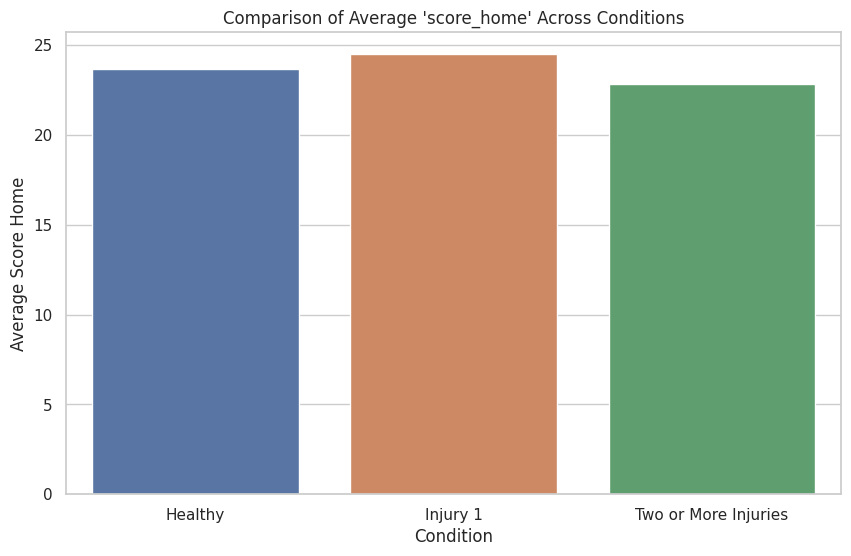

In [132]:
# @title Bar Plot for Score by #of Injuries
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have the code to create the dataframes
# ...

# Calculate the average 'score_home' for each condition
avg_score_healthy = healthy_df['score_home'].mean()
avg_score_injury_1 = injury_1_df['score_home'].mean()
avg_score_two_or_more_injuries = two_or_more_injuries_df['score_home'].mean()

# Combine the data into a single dataframe for seaborn plotting
combined_data = pd.DataFrame({
    'Condition': ['Healthy', 'Injury 1', 'Two or More Injuries'],
    'Average Score Home': [avg_score_healthy, avg_score_injury_1, avg_score_two_or_more_injuries]
})

# Set the seaborn style
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Condition', y='Average Score Home', data=combined_data, errorbar="sd", capsize=0.1)
plt.title("Comparison of Average 'score_home' Across Conditions")
plt.show()


In [133]:
# @title Avg Score by Injury Position

print("Avg score Healthy: ", healthy_df['score_home'].mean().round(1))
print("Avg score Inj. QB: ", injured_QB_df['score_home'].mean().round(1))
print("Avg score Inj. RB: ", injured_RB_df['score_home'].mean().round(1))
print("Avg score Inj. WR: ", injured_WR_df['score_home'].mean().round(1))
print("Avg score Inj. TE: ", injured_TE_df['score_home'].mean().round(1))

Avg score Healthy:  23.7
Avg score Inj. QB:  22.2
Avg score Inj. RB:  23.0
Avg score Inj. WR:  24.6
Avg score Inj. TE:  24.0


From this, we see that little can be learned from looking at score alone.

Healthy AVG Passing =  231.0  and Rushing =  118.5
Injured QB AVG Passing =  204.2  and Rushing =  118.6
Injured RB AVG Passing =  228.4  and Rushing =  120.6


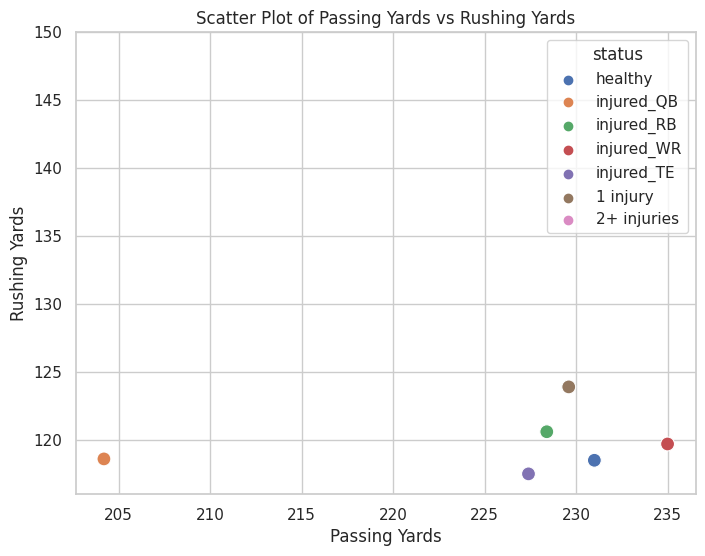

"\n###############################################################################\n# Set up the positions for each bar group\nbar_width = 0.35\nbar_positions_passing = range(len(df_stats))\nbar_positions_rushing = [pos + bar_width for pos in bar_positions_passing]\n\n\n# Create the bar graph\nplt.bar(bar_positions_passing, df_stats['mean_passing'], width=bar_width, label='Mean Passing Yards')\nplt.bar(bar_positions_rushing, df_stats['mean_rushing'], width=bar_width, label='Mean Rushing Yards')\n\n# Add labels and title\nplt.xlabel('Injury Status')\nplt.ylabel('Yards')\nplt.title('Mean Passing and Rushing Yards for Different Status')\nplt.xticks([pos + bar_width / 2 for pos in bar_positions_passing], df_stats['status'])\nplt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))\nplt.ylim(100, 240)\n# Show the plot\nplt.show()\n"

In [134]:
# @title Plots showing Passing and Rushing Yards for Teams with Injured and Healthy QB and RB
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data = healthy_df[healthy_df['passing_yards_home'], ['rushing_yards_home']]
# data needs to = passing&rushing_yards_home from healthy, injured_QB, and injured_RB dfs, so 6 columns total
# plot average. Could also consider boxplot to show distribution
# best way to get this data in one place im not sure

mean_passing_healthy = healthy_df['passing_yards_home'].mean().round(1)
mean_passing_QB = injured_QB_df['passing_yards_home'].mean().round(1)
mean_passing_RB = injured_RB_df['passing_yards_home'].mean().round(1)
mean_passing_WR = injured_WR_df['passing_yards_home'].mean().round(1)
mean_passing_TE = injured_TE_df['passing_yards_home'].mean().round(1)
mean_passing_1 = injury_1_df['passing_yards_home'].mean().round(1)
mean_passing_2_plus = two_or_more_injuries_df['passing_yards_home'].mean().round(1)

mean_rushing_healthy = healthy_df['rushing_yards_home'].mean().round(1)
mean_rushing_QB = injured_QB_df['rushing_yards_home'].mean().round(1)
mean_rushing_RB = injured_RB_df['rushing_yards_home'].mean().round(1)
mean_rushing_WR = injured_WR_df['rushing_yards_home'].mean().round(1)
mean_rushing_TE = injured_TE_df['rushing_yards_home'].mean().round(1)
mean_rushing_1 = injury_1_df['rushing_yards_home'].mean().round(1)
mean_rushing_2_plus = two_or_more_injuries_df['rushing_yards_home'].mean().round(1)

data = {
    'status': ['healthy', 'injured_QB', 'injured_RB', 'injured_WR', 'injured_TE', '1 injury', '2+ injuries'],
    'mean_passing' : [mean_passing_healthy, mean_passing_QB, mean_passing_RB, mean_passing_WR, mean_passing_TE, mean_passing_1, mean_passing_2_plus],
    'mean_rushing' : [mean_rushing_healthy, mean_rushing_QB, mean_rushing_RB, mean_rushing_WR, mean_rushing_TE, mean_rushing_1, mean_rushing_2_plus]
    }


df_stats = pd.DataFrame(data)

print('Healthy AVG Passing = ', mean_passing_healthy, ' and Rushing = ', mean_rushing_healthy)
print('Injured QB AVG Passing = ', mean_passing_QB, ' and Rushing = ', mean_rushing_QB)
print('Injured RB AVG Passing = ', mean_passing_RB, ' and Rushing = ', mean_rushing_RB)

# Set the style for the plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

sns.scatterplot(x='mean_passing', y='mean_rushing', hue='status', data=df_stats, s=100)

# Add title and labels
plt.title('Scatter Plot of Passing Yards vs Rushing Yards')
plt.xlabel('Passing Yards')
plt.ylabel('Rushing Yards')
plt.ylim(116, 150)

# Show the plot
plt.show()
'''
###############################################################################
# Set up the positions for each bar group
bar_width = 0.35
bar_positions_passing = range(len(df_stats))
bar_positions_rushing = [pos + bar_width for pos in bar_positions_passing]


# Create the bar graph
plt.bar(bar_positions_passing, df_stats['mean_passing'], width=bar_width, label='Mean Passing Yards')
plt.bar(bar_positions_rushing, df_stats['mean_rushing'], width=bar_width, label='Mean Rushing Yards')

# Add labels and title
plt.xlabel('Injury Status')
plt.ylabel('Yards')
plt.title('Mean Passing and Rushing Yards for Different Status')
plt.xticks([pos + bar_width / 2 for pos in bar_positions_passing], df_stats['status'])
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.ylim(100, 240)
# Show the plot
plt.show()
'''
# Intermediate results show decrease in Passing yards with hurt QB but do not show a decrese in rushing yards with hurt RB

As you can clearly see, an injured QB is associated with a significant drop in average passing yards (about 25), although the same cannot be said of an injured RB and rushing yards, which is interesting.

In [135]:
# @title Healthy and inj_WR avg passing
filtered_WR = games[games['home_WR_injured']]
WR_avg_passing = filtered_WR['passing_yards_home'].mean().round(1)
print('Injured WR AVG Passing : ', WR_avg_passing, '\nHealthy AVG Passing : ', healthy_df['passing_yards_home'].mean().round(1))

Injured WR AVG Passing :  235.0 
Healthy AVG Passing :  231.0


In [136]:
# @title Stats by injured position

WR_inj_avg_passing = injured_WR_df['passing_yards_home'].mean().round(1)
QB_inj_avg_passing = injured_QB_df['passing_yards_home'].mean().round(1)

TE_inj_avg_rushing = injured_TE_df['rushing_yards_home'].mean().round(1)

print(" Healthy teams average passing : ", healthy_df['passing_yards_home'].mean().round(1),
      "\n Injured WR average passing : ", WR_inj_avg_passing, "\n Injured QB average passing : ", QB_inj_avg_passing,
      "\n \n Healthy teams average rushing : ", healthy_df['rushing_yards_home'].mean().round(1),
      "\n Injured TE average rushing : ", TE_inj_avg_rushing, "\n Injured RB average rushing : ", injured_RB_df['rushing_yards_home'].mean().round(1))
print("\n Healthy average first downs: ", healthy_df['first_downs_home'].mean().round(1))
print(" Injured QB average first downs: ", injured_QB_df['first_downs_home'].mean().round(1))
print(" Injured WR average first downs: ", injured_WR_df['first_downs_home'].mean().round(1))
print(" Injured RB average first downs: ", injured_RB_df['first_downs_home'].mean().round(1))
print(" Injured TE average first downs: ", injured_TE_df['first_downs_home'].mean().round(1))

 Healthy teams average passing :  231.0 
 Injured WR average passing :  235.0 
 Injured QB average passing :  204.2 
 
 Healthy teams average rushing :  118.5 
 Injured TE average rushing :  117.5 
 Injured RB average rushing :  120.6

 Healthy average first downs:  21.1
 Injured QB average first downs:  19.2
 Injured WR average first downs:  21.0
 Injured RB average first downs:  20.7
 Injured TE average first downs:  20.5


{'Chiefs': {'healthy': 302.1, 'inj_QB': nan, 'inj_WR': 265.6, 'inj_RB': nan, 'inj_TE': 220.5, 'inj_CB': nan, 'inj_SS': nan, 'inj_HB': nan, 'inj_FB': nan}, 'Falcons': {'healthy': 252.4, 'inj_QB': 158.7, 'inj_WR': 176.2, 'inj_RB': 269.7, 'inj_TE': 194.2, 'inj_CB': nan, 'inj_SS': nan, 'inj_HB': nan, 'inj_FB': nan}, 'Bills': {'healthy': 234.0, 'inj_QB': nan, 'inj_WR': 258.9, 'inj_RB': 221.8, 'inj_TE': nan, 'inj_CB': nan, 'inj_SS': nan, 'inj_HB': nan, 'inj_FB': nan}, 'Lions': {'healthy': 277.5, 'inj_QB': 248.8, 'inj_WR': 251.2, 'inj_RB': 265.6, 'inj_TE': nan, 'inj_CB': 211.3, 'inj_SS': nan, 'inj_HB': nan, 'inj_FB': nan}, 'Vikings': {'healthy': 262.7, 'inj_QB': nan, 'inj_WR': 295.0, 'inj_RB': 252.1, 'inj_TE': 256.1, 'inj_CB': nan, 'inj_SS': nan, 'inj_HB': nan, 'inj_FB': nan}, 'Patriots': {'healthy': 124.9, 'inj_QB': 238.0, 'inj_WR': 248.4, 'inj_RB': nan, 'inj_TE': 245.2, 'inj_CB': nan, 'inj_SS': nan, 'inj_HB': nan, 'inj_FB': nan}, 'Commanders': {'healthy': 216.6, 'inj_QB': 171.0, 'inj_WR': 1

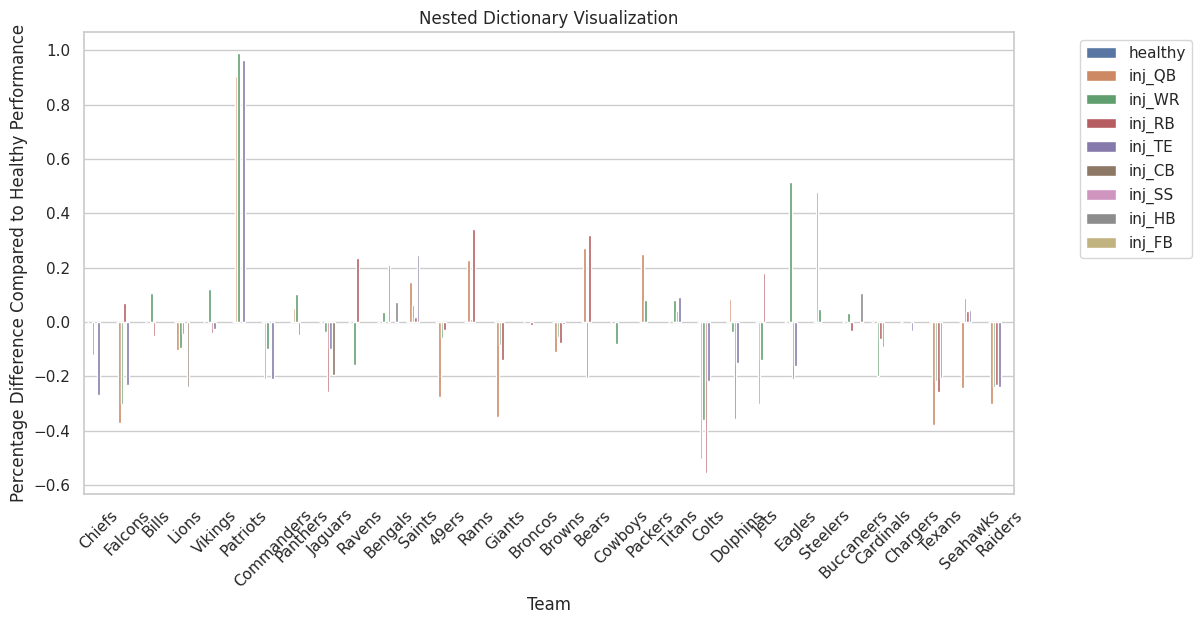

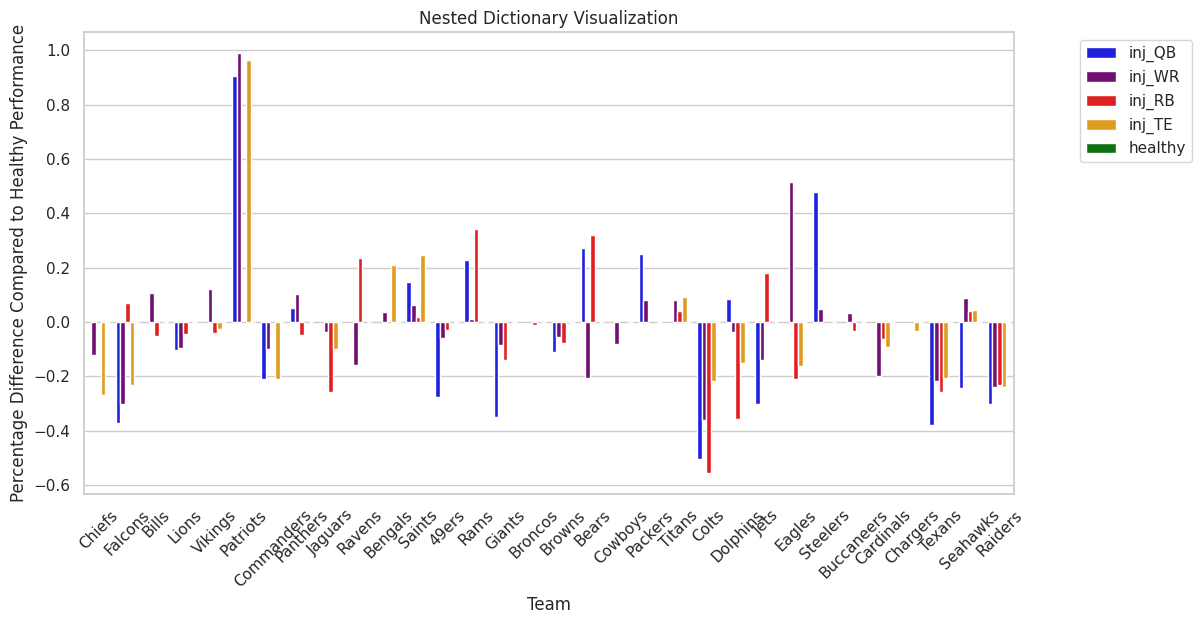

In [137]:
# @title Analysis by Individual Teams & Specific Position
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# this code was used to look at multiple variables, most recently passing yards. Other outputs cleared to remove clutter and redundancy

teams = games['home'].unique()

# List of DataFrames
team_dfs = [healthy_df, injured_QB_df, injured_WR_df, injured_RB_df, injured_TE_df,
            injured_CB_df, injured_SS_df, injured_HB_df, injured_FB_df]

# List of DataFrame names
df_names = ['healthy', 'inj_QB', 'inj_WR', 'inj_RB', 'inj_TE', 'inj_CB', 'inj_SS', 'inj_HB', 'inj_FB']

def get_averages(stat):
  team_averages_dict = {}
  for team in teams:
    status_dict = {}
    for df, df_name in zip(team_dfs, df_names):
        filtered_df = df[df['home'] == team]
        mean_stat = filtered_df[stat].mean()
        mean_stat_rounded = round(mean_stat, 1)
        status_dict[df_name] = mean_stat_rounded
        #print(f'Team: {team}, DataFrame: {df_name}, Mean {stat}: {mean_stat_rounded}')
    #print("\n")
    team_averages_dict[team] = status_dict

  return team_averages_dict

# This is a good start. Next we will want to somehow save these values or otherwise be able to access them to perform calculations
# Interesting calculations would be maybe percentage difference between each inj_pos and healthy?

team_status_mean_passing = get_averages('passing_yards_home')

def get_percentage_diff(averages_dict):
  percentage_diff_dict = {}
  for team, status_dict in averages_dict.items():
    team_diff_dict = {}
    baseline = status_dict['healthy']
    for status, value in status_dict.items():
      percentage_diff = -(baseline - value) / baseline
      team_diff_dict[status] = percentage_diff.round(4)
    percentage_diff_dict[team] = team_diff_dict
  return percentage_diff_dict

mean_passing_percentage_diff_dict = get_percentage_diff(team_status_mean_passing)
print(team_status_mean_passing)
print(mean_passing_percentage_diff_dict)

# the next 4 lines get the number of games each team played with an injured QB
# the results are pretty low, so results of team specific analysis won't be very meaningful
num_of_games_played_with_inj_QB = {}
for team in teams:
  num_of_games_played_with_inj_QB[team] = len(injured_QB_df[injured_QB_df['home'] == team])
num_of_games_played_with_inj_QB_sorted = dict(sorted(num_of_games_played_with_inj_QB.items(), key=lambda x: x[1], reverse=True))

print(num_of_games_played_with_inj_QB_sorted)
lions_home = len(games[games['home'] == 'Lions'])
lions_away = len(games[games['away'] == 'Lions'])
lions_num_games = lions_home + lions_away
print("Number of games played by the Lions total: ", lions_num_games)

# Flatten the nested dictionary into lists for plotting
teams = []
statuses = []
values = []

for team, status_dict in mean_passing_percentage_diff_dict.items():
    for status, value in status_dict.items():
        teams.append(team)
        statuses.append(status)
        values.append(value)

# Create a DataFrame from the lists
passing_percentage_diff_df = pd.DataFrame({'Team': teams, 'Status': statuses, 'Value': values})

plt.figure(figsize=(12, 6))
sns.barplot(x='Team', y='Value', hue='Status', data=passing_percentage_diff_df)
plt.title('Nested Dictionary Visualization')
plt.ylabel('Percentage Difference Compared to Healthy Performance')
plt.xticks(rotation = 45)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

# Select relevant statuses
relevant_statuses = ['inj_QB', 'inj_WR', 'inj_RB', 'inj_TE', 'healthy']

status_colors = {
    'inj_QB': 'blue',   # blue for inj_QB (RGB)
    'inj_WR': 'purple',          # purple for inj_WR (RGB)
    'inj_RB': 'red',     # red for inj_RB (RGB)
    'inj_TE': 'orange',    # orange for inj_TE (RGB)
    'healthy': 'green'
}
legend_order = ['inj_QB', 'inj_WR', 'inj_RB', 'inj_TE', 'healthy']
# Set the custom color palette
custom_palette = [status_colors[status] for status in relevant_statuses]

# Filter the DataFrame to include only the relevant statuses
passing_percentage_diff_df_filtered = passing_percentage_diff_df[passing_percentage_diff_df['Status'].isin(relevant_statuses)]

# Create a grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Team', y='Value', hue='Status', data=passing_percentage_diff_df_filtered, palette=custom_palette, hue_order=legend_order)
plt.title('Nested Dictionary Visualization')
plt.ylabel('Percentage Difference Compared to Healthy Performance')
plt.xticks(rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

# Colors in the wrong order!!

Imperfect visualization, but this is a difficult thing to visualize with so many variables. Here, a negative value represents a decrease in passing yards for that injury status compared to the baseline (which is that specific team's performance when healthy), and a positive bar represents an increase. Notice that while the majority of bars are negative, this majority is unexpectedly small and little can be learned from this summary.

We might expect to find an increase in passing yards with injured TE or RB, but that does not seem to be the case.

Still the only noticeable association is injured QB and decreased passing yards.

In [138]:
# @title Comparing Position Injuries and Possession Time Across Injury Statuses
from datetime import datetime, timedelta, time

healthy_posession = healthy_df['possession_home']
QB_posession = injured_QB_df['possession_home']
WR_posession = injured_WR_df['possession_home']
RB_posession = injured_RB_df['possession_home']
TE_posession = injured_TE_df['possession_home']

categories = [healthy_posession, QB_posession, WR_posession, RB_posession, TE_posession]

def get_average_times(categories):
  times = []
  for cat in categories:
    # Convert datetime.time to seconds since midnight
    seconds_since_midnight = [t.hour * 3600 + t.minute * 60 + t.second for t in cat.values]

    # Calculate the average in seconds
    average_seconds = sum(seconds_since_midnight) // len(seconds_since_midnight)

    # Convert back to datetime.datetime
    average_datetime = datetime.combine(datetime.today(), time(0, 0, 0)) + timedelta(seconds=average_seconds)

    # Format as a string
    formatted_time = average_datetime.strftime('%H:%M:%S')

    times.append(formatted_time)
  return times

avg_times = get_average_times(categories)

def get_average_time(category):
    # Convert datetime.time to seconds since midnight
    seconds_since_midnight = [t.hour * 3600 + t.minute * 60 + t.second for t in category]

    # Calculate the average in seconds
    average_seconds = sum(seconds_since_midnight) // len(seconds_since_midnight)

    # Convert back to datetime.datetime
    average_datetime = datetime.combine(datetime.today(), time(0, 0, 0)) + timedelta(seconds=average_seconds)

    # Format as a string
    formatted_time = average_datetime.strftime('%H:%M:%S')

    return formatted_time

avg_healthy_possession = get_average_time(healthy_df['possession_home'])
avg_1_injury_possession = get_average_time(injury_1_df['possession_home'])
avg_2_or_more_injuries_possession = get_average_time(two_or_more_injuries_df['possession_home'])

print("Average Healthy Possession: ", avg_healthy_possession, " Number of rows: ", len(healthy_df))
print("Average 1 Injury Possession: ", avg_1_injury_possession, " Number of rows: ", len(injury_1_df))
print("Average 2+ Injury Possession: ", avg_2_or_more_injuries_possession, " Number of rows: ", len(two_or_more_injuries_df))

print("Average Possession w/ Hurt QB: ", get_average_time(injured_QB_df['possession_home']), " Number of rows: ", len(injured_QB_df))
print("Average Possession w/ Hurt RB: ", get_average_time(injured_RB_df['possession_home']), " Number of rows: ", len(injured_RB_df))
print("Average Possession w/ Hurt TE: ", get_average_time(injured_TE_df['possession_home']), " Number of rows: ", len(injured_TE_df))
print("Average Possession w/ Hurt WR: ", get_average_time(injured_WR_df['possession_home']), " Number of rows: ", len(injured_WR_df))
print("Average Possession w/ Hurt HB: ", get_average_time(injured_HB_df['possession_home']), " Number of rows: ", len(injured_HB_df))
print("Average Possession w/ Hurt CB: ", get_average_time(injured_CB_df['possession_home']), " Number of rows: ", len(injured_CB_df))
'''
print("Average Possession w/ Hurt SS: ", get_average_time(injured_SS_df['possession_home']))
print("Average Possession w/ Hurt FB: ", get_average_time(injured_FB_df['possession_home']))

Both of these dfs are empty - no records of injured SS or FB.
'''

print('Minimum Possession Time: ', games['possession_home'].min(), '\nMaximum Possession Time: ', games['possession_home'].max())

time = games['possession_home'].apply(lambda x: x.minute + x.second / 60)

q1 = time.quantile(0.25)
q3 = time.quantile(0.75)
poss_iqr = q3 - q1
print('Possession Time IQR: ', poss_iqr)


Average Healthy Possession:  00:30:04  Number of rows:  296
Average 1 Injury Possession:  00:30:10  Number of rows:  305
Average 2+ Injury Possession:  00:29:44  Number of rows:  168
Average Possession w/ Hurt QB:  00:29:16  Number of rows:  77
Average Possession w/ Hurt RB:  00:29:36  Number of rows:  158
Average Possession w/ Hurt TE:  00:29:41  Number of rows:  189
Average Possession w/ Hurt WR:  00:30:40  Number of rows:  218
Average Possession w/ Hurt HB:  00:33:41  Number of rows:  17
Average Possession w/ Hurt CB:  00:26:22  Number of rows:  9
Minimum Possession Time:  00:18:25 
Maximum Possession Time:  00:46:04
Possession Time IQR:  6.600000000000001


In [139]:
# @title Possession Time f_oneway with scipy.stats
from scipy.stats import f_oneway

healthy = healthy_df['possession_home'].apply(lambda x: x.minute + x.second / 60)
injury_1 = injury_1_df['possession_home'].apply(lambda x: x.minute + x.second / 60)
injury_2plus = two_or_more_injuries_df['possession_home'].apply(lambda x: x.minute + x.second / 60)
inj_QB = injured_QB_df['possession_home'].apply(lambda x: x.minute + x.second / 60)
inj_RB = injured_RB_df['possession_home'].apply(lambda x: x.minute + x.second / 60)
inj_TE = injured_TE_df['possession_home'].apply(lambda x: x.minute + x.second / 60)
inj_WR = injured_WR_df['possession_home'].apply(lambda x: x.minute + x.second / 60)

# Perform ANOVA
f_statistic, p_value = f_oneway(healthy, injury_1, injury_2plus, inj_QB, inj_RB, inj_TE, inj_WR)

# Print the results
print(f'F-Statistic: {f_statistic}')
print(f'P-Value: {p_value}')

# Compare p-value to significance level (α)
if p_value < 0.05:  # or your chosen significance level
    print('Reject the null hypothesis. There are significant differences.')
else:
    print('Fail to reject the null hypothesis. No significant differences found.')


F-Statistic: 1.5344192093452318
P-Value: 0.16319679530520567
Fail to reject the null hypothesis. No significant differences found.


In [140]:
# @title Win% by Injury Status

healthy_win_percent = round(healthy_df['home_win'].sum() / len(healthy_df), 2)
one_injury_win_percent = round(injury_1_df['home_win'].sum() / len(injury_1_df), 2)
two_or_more_win_percent = round(two_or_more_injuries_df['home_win'].sum() / len(two_or_more_injuries_df), 2)

inj_WR_win_percent = round(injured_WR_df['home_win'].sum() / len(injured_WR_df), 2)
inj_RB_win_percent = round(injured_RB_df['home_win'].sum() / len(injured_RB_df), 2)
inj_TE_win_percent = round(injured_TE_df['home_win'].sum() / len(injured_TE_df), 2)
inj_QB_win_percent = round(injured_QB_df['home_win'].sum() / len(injured_QB_df), 2)
inj_HB_win_percent = round(injured_HB_df['home_win'].sum() / len(injured_HB_df), 2)
inj_CB_win_percent = round(injured_CB_df['home_win'].sum() / len(injured_CB_df), 2)


win_percentages = [healthy_win_percent, one_injury_win_percent, two_or_more_win_percent, inj_WR_win_percent, inj_RB_win_percent, inj_TE_win_percent, inj_QB_win_percent]

print("Healthy win percentage: ", healthy_win_percent)
print("1 Injury win percentage: ", one_injury_win_percent)
print("2+ Injuries win percentage: ", two_or_more_win_percent)
for pos, perc in zip(positions, win_percentages[3:]):
  print("Injured ", pos, " win percentage: ", perc)

print("WR --> ", inj_WR_win_percent)

Healthy win percentage:  0.53
1 Injury win percentage:  0.53
2+ Injuries win percentage:  0.48
Injured  WR  win percentage:  0.56
Injured  RB  win percentage:  0.46
Injured  TE  win percentage:  0.51
Injured  QB  win percentage:  0.44
WR -->  0.56


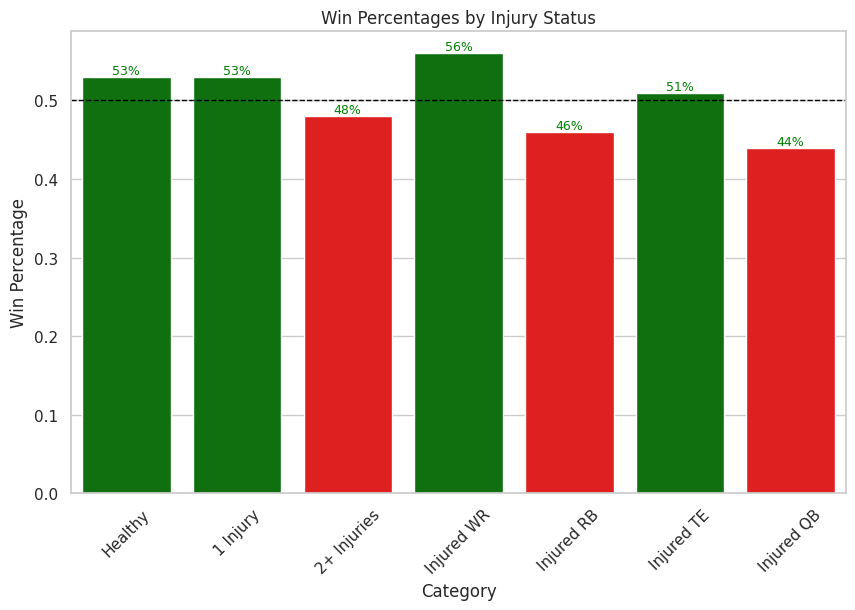

In [141]:
# @title Visualize Win Percentages Among Categories on Injury Statuses

# Ensure that both keys have the same number of elements
categories = ['Healthy', '1 Injury', '2+ Injuries', 'Injured WR', 'Injured RB', 'Injured TE', 'Injured QB']

data = {
    'Category': categories,
    'Value': win_percentages
}

colors = ["green" if value > 0.5 else "red" if value < 0.5 else "grey" for value in data['Value']]


df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Category', y='Value', data=df, palette=colors)

# Add a horizontal line at the baseline
plt.axhline(y=.5, color='black', linestyle='--', linewidth=1)

# Annotate each bar with the actual values
for i, value in enumerate(df['Value']):
    text_color = 'red' if df['Value'][i] < 0 else 'green'
    vertical_alignment = 'top' if df['Value'][i] < 0 else 'bottom'
    ax.text(i, df['Value'][i], f'{value:.0%}', ha='center', va=vertical_alignment, color=text_color, fontsize=9)

# Set labels and title
plt.xlabel('Category')
plt.ylabel('Win Percentage')
plt.title('Win Percentages by Injury Status')
plt.xticks(rotation=45)

plt.show()


Other than Healthy teams, none of these categories are expected to be green, and no category should have a higher win% than 'Healthy' (i.e. no injury should increase odds of winning).

Still, it is interesting that an injured RB is associated with a lower Win% than 2+ Injuries, and that Injured QB Win% is even lower than RB. This potentially indicates that QB and RB are respectively the most influential positions, with both of them having a greater impact than 2 or more misc. injuries on average.

In [142]:
# @title scikit-learn ML Random Forest Classifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming you have a DataFrame named 'games' with columns including 'injured_WR', 'injured_RB', etc.
# and a column 'result' indicating whether the team won or lost (1 for win, 0 for loss).

# Create a feature matrix X (injury information) and target variable y (result)
X = games[[f'home_{position}_injured' for position in positions] + [f'away_{position}_injured' for position in positions]]
y = games['home_win']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a RandomForestClassifier (you can choose another classifier as well)
clf = RandomForestClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.54
              precision    recall  f1-score   support

       False       0.48      0.38      0.42        69
        True       0.57      0.67      0.62        85

    accuracy                           0.54       154
   macro avg       0.53      0.52      0.52       154
weighted avg       0.53      0.54      0.53       154



In [143]:
# @title Logistic Regression sklearn

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


X = games[[f'home_{position}_injured' for position in positions] + [f'away_{position}_injured' for position in positions]]

# using only home injuries to predict (below) results in Accuracy = .55 :
#X = games[[f'home_{position}_injured' for position in positions]]

y = games['home_win']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and Train Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))


Accuracy: 0.58
              precision    recall  f1-score   support

       False       0.54      0.51      0.52        69
        True       0.62      0.65      0.63        85

    accuracy                           0.58       154
   macro avg       0.58      0.58      0.58       154
weighted avg       0.58      0.58      0.58       154



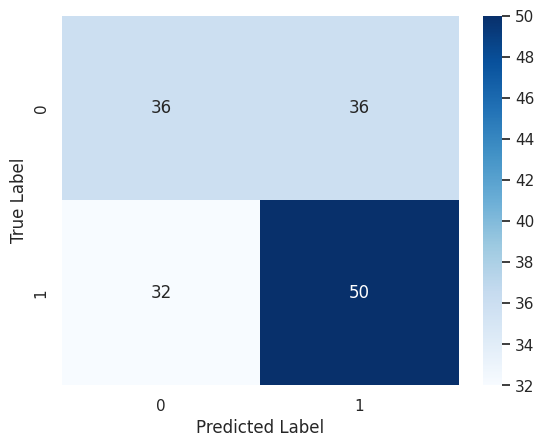

Accuracy: 0.56


In [144]:
# @title Gaussian Naive Bayes

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

X = games[[f'home_{position}_injured' for position in positions] + [f'away_{position}_injured' for position in positions]]
y = games['home_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

gnb = GaussianNB()

y_pred = gnb.fit(X_train, y_train).predict(X_test)
'''
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
'''

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")


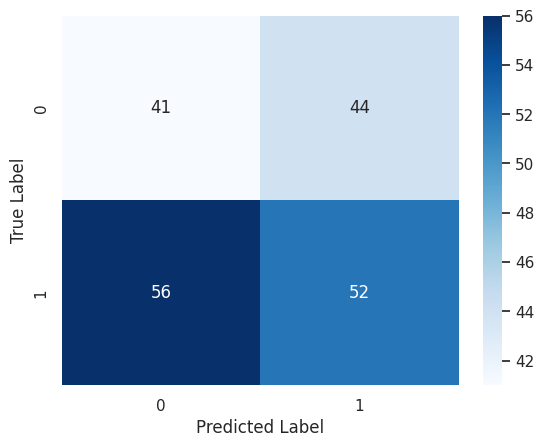

Accuracy: 0.48


In [145]:
# @title Gaussian Naive Bayes

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Combine boolean Series and reshape to a 2D array
X = np.array(games['home_WR_injured'] + games['away_WR_injured']).reshape(-1, 1)
y = games['home_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

gnb = GaussianNB()

y_pred = gnb.fit(X_train, y_train).predict(X_test)
'''
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
'''

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")


Can scrape data from table at https://www.sportsoddshistory.com/nfl-game-odds/ (Favorites --> Straight Up --> %) or refer to reference in Final Report and notice that Favorites win on average 65.6% of the time. ("Odds courtesy of Pro-Football-Reference.com")

My model predicts winners with 58% Accuracy. Not bad considering the limitations on variables, but not strong statistical evidence by any means.

In [146]:
# @title Chi Squared with select injuries on home team loss
import numpy as np
from sklearn.feature_selection import chi2
import numpy as np

games['home_loss'] = np.where(games['home_win'] == False, True, False)

# input variables
X = games[['home_QB_injured', 'home_RB_injured', 'home_TE_injured']]

# output variable
y = games['home_loss']

# Convert boolean values to integers (True -> 1, False -> 0)
X = X.astype(int)

# chi-squared test
chi2_stat, p_values = chi2(X, y)

print("Chi-squared statistics:")
print(chi2_stat)

print("\nP-values:")
print(p_values)


Chi-squared statistics:
[1.78105496 1.951225   0.01417694]

P-values:
[0.18201984 0.16245491 0.90522231]


In [147]:
# @title print length of datasets
# length here is number of records of teams with that injury
for pos in positions:
    posdf_name = f'injured_{pos}_df'
    posdf = globals()[posdf_name]
    print(pos, " length: ", len(posdf))


WR  length:  218
RB  length:  158
TE  length:  189
QB  length:  77
HB  length:  17
CB  length:  9
SS  length:  0
FB  length:  0


In [148]:
# @title MANOVA for injury types and various metrics
import pandas as pd
from statsmodels.multivariate.manova import MANOVA

df = games
# Convert boolean to integer for MANOVA

df['home_QB_injured'] = df['home_QB_injured'].astype(int)
df['home_WR_injured'] = df['home_WR_injured'].astype(int)
df['home_RB_injured'] = df['home_RB_injured'].astype(int)
df['home_TE_injured'] = df['home_TE_injured'].astype(int)

# Specify the model
model = MANOVA.from_formula('passing_yards_home + rushing_yards_home + total_yards_home + first_downs_home + possession_home_minutes ~ home_WR_injured + home_QB_injured + home_RB_injured  + home_TE_injured', data=df)

# Print MANOVA results
print(model.mv_test())


                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept         Value  Num DF  Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda  0.0423 4.0000 761.0000 4303.4868 0.0000
         Pillai's trace  0.9577 4.0000 761.0000 4303.4868 0.0000
 Hotelling-Lawley trace 22.6202 4.0000 761.0000 4303.4868 0.0000
    Roy's greatest root 22.6202 4.0000 761.0000 4303.4868 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
       home_WR_injured     Value  Num DF  Den DF  F Value Pr > F
----------------------------------------------------------------
             Wilks' lambda 0.9856 4.0000 761.0000  2.7705 0.0264
            Pillai's trace 0.0144 4.0000 761.

In [149]:
# @title point biserial injured_QB and passing yards
from scipy.stats import pointbiserialr

# Calculate point-biserial correlation
corr_coeff, p_value = pointbiserialr(df['home_QB_injured'], df['passing_yards_home'])

# Print the correlation coefficient and p-value
print(f"Point-Biserial Correlation Coefficient: {corr_coeff}")
print(f"P-value: {p_value}")


Point-Biserial Correlation Coefficient: -0.11291556965643369
P-value: 0.0017116056319470953


In [150]:
# @title point biserial with injured_QB and first downs
corr_coeff, p_value = pointbiserialr(df['home_QB_injured'], df['first_downs_home'])

# Print the correlation coefficient and p-value
print(f"Point-Biserial Correlation Coefficient: {corr_coeff}")
print(f"P-value: {p_value}")


Point-Biserial Correlation Coefficient: -0.11691344555227688
P-value: 0.0011622747059219759


In [151]:
# @title Ordinary Least Squares Regression w/ injured QB and Passing Yards
import statsmodels.api as sm

X = sm.add_constant(games['home_QB_injured'].astype(int))  # Convert boolean to 0 or 1
y = games['passing_yards_home']

model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())
import statsmodels.api as sm


                            OLS Regression Results                            
Dep. Variable:     passing_yards_home   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     9.905
Date:                Sat, 09 Dec 2023   Prob (F-statistic):            0.00171
Time:                        01:55:47   Log-Likelihood:                -4411.0
No. Observations:                 769   AIC:                             8826.
Df Residuals:                     767   BIC:                             8835.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             232.6286      2.854     

In [152]:
# @title Calculate continuous average passing yards for each record
teams = games['home'].unique()
passing_avgs_dict = dict.fromkeys(teams, 0.0)
teams_total_passing_dict = dict.fromkeys(teams, 0.0)
teams_num_games_dict = dict.fromkeys(teams, 0.0)

DF = games.sort_values(by=['season', 'week'])
DF['home_avg_passing'] = 0.0
DF['away_avg_passing'] = 0.0

season = DF['season'][1]

for index, row in DF.iterrows():
  if not row['season'] == season:
    season = row['season']
    passing_avgs_dict = dict.fromkeys(teams, 0.0)
    teams_total_passing_dict = dict.fromkeys(teams, 0.0)
    teams_num_games_dict = dict.fromkeys(teams, 0.0)

  away = row['away']
  home = row['home']
  away_passing = row['passing_yards_away']
  home_passing = row['passing_yards_home']

  teams_total_passing_dict[away] += away_passing
  teams_total_passing_dict[home] += home_passing
  teams_num_games_dict[away] += 1
  teams_num_games_dict[home] += 1

  away_avg = round(teams_total_passing_dict[away] / teams_num_games_dict[away], 1)
  home_avg = round(teams_total_passing_dict[home] / teams_num_games_dict[home], 1)

  passing_avgs_dict[away] = away_avg
  passing_avgs_dict[home] = home_avg

  #row['home_avg_passing'] = home_avg
  DF.at[index, 'home_avg_passing'] = home_avg
  DF.at[index, 'away_avg_passing'] = away_avg


checkit = DF[['season', 'week', 'home', 'away', 'passing_yards_home', 'passing_yards_away', 'home_avg_passing', 'away_avg_passing']]
checkit = checkit.sort_values(by=['season', 'week', 'home'])
display(checkit.head(50))

'''
niners_wk4 = DF[(DF['season'] == 2020) & (DF['week'] == 4) & (DF['home'] == "49ers")]

df_2021 = DF[DF['season'] == 2021]
df_2022 = DF[DF['season'] == 2022]
df_2021 = df_2021[['season', 'week', 'home', 'away', 'passing_yards_home', 'passing_yards_away', 'home_avg_passing']]

#display(df_2021[df_2021['week'] < 4])
display(games[(games['season'] == 2021) & (games['home'] == 'Raiders')])
'''

,season,week,home,away,passing_yards_home,passing_yards_away,home_avg_passing,away_avg_passing
12,2020,1,49ers,Cardinals,243,224,243.0,224.0
10,2020,1,Bengals,Chargers,173,207,173.0,207.0
2,2020,1,Bills,Jets,306,202,306.0,202.0
15,2020,1,Broncos,Titans,216,247,216.0,247.0
0,2020,1,Chiefs,Texans,203,242,203.0,242.0
6,2020,1,Commanders,Eagles,159,208,159.0,208.0
1,2020,1,Falcons,Seahawks,434,299,434.0,299.0
14,2020,1,Giants,Steelers,262,208,262.0,208.0
8,2020,1,Jaguars,Colts,150,357,150.0,357.0
3,2020,1,Lions,Bears,288,214,288.0,214.0


'\nniners_wk4 = DF[(DF[\'season\'] == 2020) & (DF[\'week\'] == 4) & (DF[\'home\'] == "49ers")]\n\ndf_2021 = DF[DF[\'season\'] == 2021]\ndf_2022 = DF[DF[\'season\'] == 2022]\ndf_2021 = df_2021[[\'season\', \'week\', \'home\', \'away\', \'passing_yards_home\', \'passing_yards_away\', \'home_avg_passing\']]\n\n#display(df_2021[df_2021[\'week\'] < 4])\ndisplay(games[(games[\'season\'] == 2021) & (games[\'home\'] == \'Raiders\')])\n'

We had hoped that using a team's current average passing yards combined with their QB injury status might show something revealing/significant about actual passing yards or predicted win/loss, but it did not. See below.

In [153]:
# @title mean squared error linear regression [injured_QB, avg_passing] --> passing_yards
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df = DF

X = df[['home_QB_injured', 'home_avg_passing']]
y = df['passing_yards_home']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 4811.087754895906


In [154]:
# @title MANOVA
from statsmodels.multivariate.manova import MANOVA
# Convert boolean to integer for MANOVA
df = DF

df['home_QB_injured'] = df['home_QB_injured'].astype(int)
df['home_WR_injured'] = df['home_WR_injured'].astype(int)
df['home_RB_injured'] = df['home_RB_injured'].astype(int)

# Specify the model
model = MANOVA.from_formula('home_QB_injured + home_avg_passing ~ passing_yards_home + first_downs_home', data=df)

# Print MANOVA results
print(model.mv_test())


                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept        Value  Num DF  Den DF  F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.4809 2.0000 765.0000 412.9534 0.0000
         Pillai's trace 0.5191 2.0000 765.0000 412.9534 0.0000
 Hotelling-Lawley trace 1.0796 2.0000 765.0000 412.9534 0.0000
    Roy's greatest root 1.0796 2.0000 765.0000 412.9534 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
    passing_yards_home   Value  Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
           Wilks' lambda 0.7936 2.0000 765.0000 99.4839 0.0000
          Pillai's trace 0.2064 2.0000 765.0000 99.4839 0.0000
  Hotelling

In [155]:
# @title Multiple Linear Regression Attempt
X = DF[['home_QB_injured', 'home_avg_passing']]
X = sm.add_constant(X)  # Add a constant term for the intercept

y = DF['passing_yards_home']

# Fit the multiple linear regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     passing_yards_home   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     177.2
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           5.56e-64
Time:                        01:55:47   Log-Likelihood:                -4269.7
No. Observations:                 769   AIC:                             8545.
Df Residuals:                     766   BIC:                             8559.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.4421     12.912  

In [156]:
# @title Logistic Regression With Average Passing yds
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Selecting injury columns
injury_columns_home = [f'home_{position}_injured' for position in positions]
injury_columns_away = [f'away_{position}_injured' for position in positions]

# Concatenating injury columns and average passing columns
X = DF[['home_QB_injured', 'away_QB_injured', 'home_avg_passing', 'away_avg_passing']]

#X = DF[[f'home_{position}_injured' for position in positions] + [f'away_{position}_injured' for position in positions] + DF['home_avg_passing'] + DF['away_avg_passing']]

# using only home injuries to predict (below) results in Accuracy = .55 :
#X = games[[f'home_{position}_injured' for position in positions]]

y = games['home_win']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and Train Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))


Accuracy: 0.51
              precision    recall  f1-score   support

       False       0.46      0.45      0.45        69
        True       0.56      0.56      0.56        85

    accuracy                           0.51       154
   macro avg       0.51      0.51      0.51       154
weighted avg       0.51      0.51      0.51       154



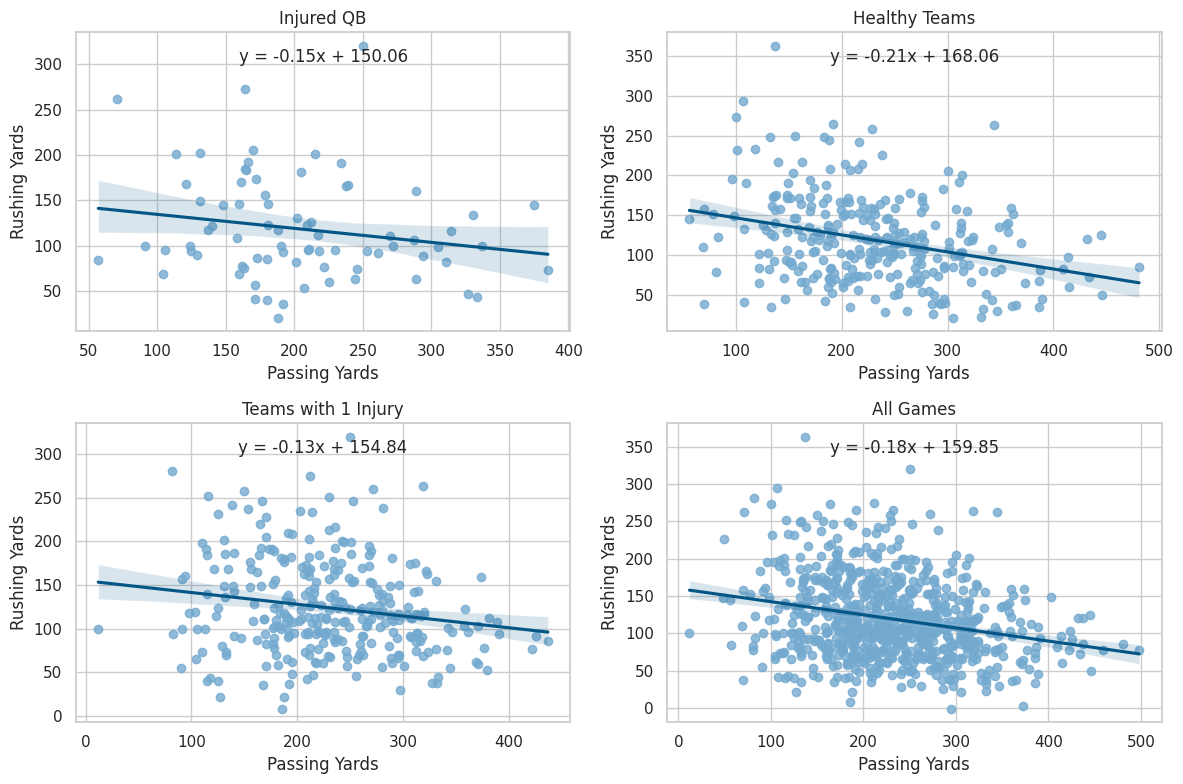

In [157]:
# @title Scatter Plots for Passing/Rushing by Status w/ Regression Line

data1 = {'x' : injured_QB_df['passing_yards_home'], 'y' : injured_QB_df['rushing_yards_home']}
data2 = {'x': healthy_df['passing_yards_home'], 'y' : healthy_df['rushing_yards_home']}
data3 = {'x' : injury_1_df['passing_yards_home'], 'y' : injury_1_df['rushing_yards_home']}
data4 = {'x' : games['passing_yards_home'], 'y' : games['rushing_yards_home']}

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Scatter plot for data1
sns.regplot(x='x', y='y', data=data1, ax=axes[0, 0], scatter_kws={'color':sns.color_palette('PuBu', n_colors=1)[0]}, line_kws={'color': sns.color_palette('PuBu', n_colors=8)[7]})

axes[0, 0].set_title('Injured QB')

slope, intercept = np.polyfit(data1['x'], data1['y'], 1)
equation = f'y = {slope:.2f}x + {intercept:.2f}'
axes[0, 0].annotate(equation, xy=(0.5, 0.9), xycoords='axes fraction', ha='center')
axes[0, 0].set_xlabel('Passing Yards')
axes[0, 0].set_ylabel('Rushing Yards')

# Scatter plot for data2
sns.regplot(x='x', y='y', data=data2, ax=axes[0, 1], scatter_kws={'color':sns.color_palette('PuBu', n_colors=1)[0]}, line_kws={'color': sns.color_palette('PuBu', n_colors=8)[7]})
axes[0, 1].set_title('Healthy Teams')

slope, intercept = np.polyfit(data2['x'], data2['y'], 1)
equation = f'y = {slope:.2f}x + {intercept:.2f}'
axes[0, 1].annotate(equation, xy=(0.5, 0.9), xycoords='axes fraction', ha='center')
axes[0, 1].set_xlabel('Passing Yards')
axes[0, 1].set_ylabel('Rushing Yards')

# Scatter plot for data3
sns.regplot(x='x', y='y', data=data3, ax=axes[1, 0], scatter_kws={'color':sns.color_palette('PuBu', n_colors=1)[0]}, line_kws={'color': sns.color_palette('PuBu', n_colors=8)[7]})
axes[1, 0].set_title('Teams with 1 Injury')

slope, intercept = np.polyfit(data3['x'], data3['y'], 1)
equation = f'y = {slope:.2f}x + {intercept:.2f}'
axes[1, 0].annotate(equation, xy=(0.5, 0.9), xycoords='axes fraction', ha='center')
axes[1, 0].set_xlabel('Passing Yards')
axes[1, 0].set_ylabel('Rushing Yards')

# Scatter plot for data4
sns.regplot(x='x', y='y', data=data4, ax=axes[1, 1], scatter_kws={'color':sns.color_palette('PuBu', n_colors=1)[0]}, line_kws={'color': sns.color_palette('PuBu', n_colors=8)[7]})

axes[1, 1].set_title('All Games')

slope, intercept = np.polyfit(data4['x'], data4['y'], 1)
equation = f'y = {slope:.2f}x + {intercept:.2f}'
axes[1, 1].annotate(equation, xy=(0.5, 0.9), xycoords='axes fraction', ha='center')
axes[1, 1].set_xlabel('Passing Yards')
axes[1, 1].set_ylabel('Rushing Yards')


# Adjust layout
plt.tight_layout()
plt.show()


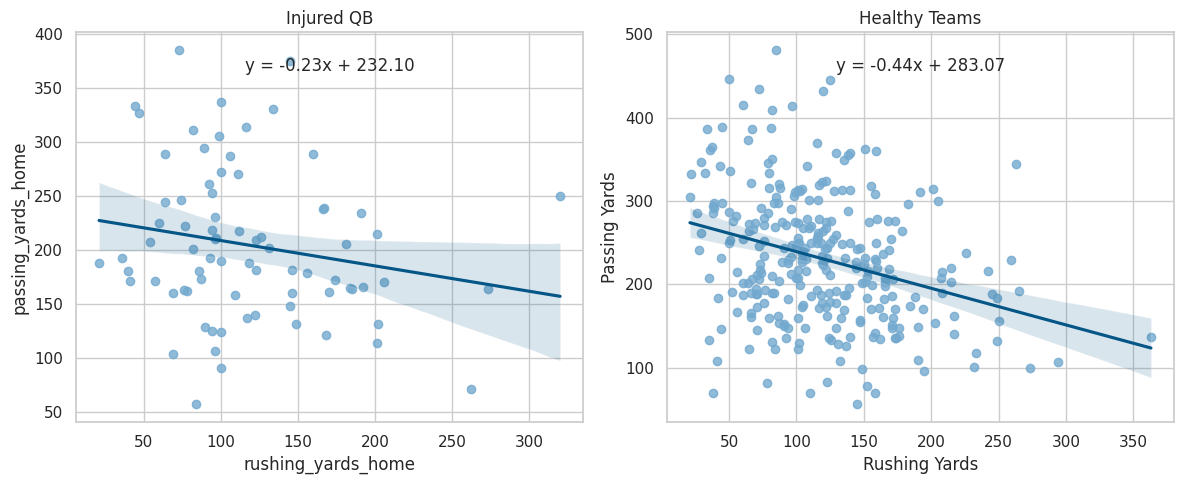

In [158]:
# @title Scatter Plots for Rushing/Passing by Status w/ Regression Line
data1 = {'x': injured_QB_df['rushing_yards_home'], 'y': injured_QB_df['passing_yards_home']}
data2 = {'x': healthy_df['rushing_yards_home'], 'y': healthy_df['passing_yards_home']}

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot for data1
sns.regplot(x='x', y='y', data=data1, ax=axes[0], scatter_kws={'color': sns.color_palette('PuBu', n_colors=1)[0]},
            line_kws={'color': sns.color_palette('PuBu', n_colors=8)[7]})

axes[0].set_title('Injured QB')
slope, intercept = np.polyfit(data1['x'], data1['y'], 1)
equation = f'y = {slope:.2f}x + {intercept:.2f}'
axes[0].annotate(equation, xy=(0.5, 0.9), xycoords='axes fraction', ha='center')

# Scatter plot for data2
sns.regplot(x='x', y='y', data=data2, ax=axes[1], scatter_kws={'color': sns.color_palette('PuBu', n_colors=1)[0]},
            line_kws={'color': sns.color_palette('PuBu', n_colors=8)[7]})

axes[1].set_title('Healthy Teams')
slope, intercept = np.polyfit(data2['x'], data2['y'], 1)
equation = f'y = {slope:.2f}x + {intercept:.2f}'
axes[1].annotate(equation, xy=(0.5, 0.9), xycoords='axes fraction', ha='center')

plt.ylabel('Passing Yards')
plt.xlabel('Rushing Yards')

# Adjust layout
plt.tight_layout()
plt.show()


In [159]:
# @title Get requirements.txt
!pip freeze >> requirements.txt